In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, \
precision_recall_fscore_support, roc_curve, plot_roc_curve,roc_auc_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as Pipeline

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('data/cleaned_topics_reduced.csv').drop('cleaned',axis=1)

In [5]:
df

,medical_specialty,transcription,cleaned_lemma
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","['leave', 'atrial', 'enlargement', 'leave', 'a..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"['leave', 'ventricular', 'cavity', 'size', 'wa..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","['echocardiogram', 'multiple', 'view', 'heart'..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","['description', 'normal', 'cardiac', 'chamber'..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","['mild', 'aortic', 'stenosis', 'widely', 'calc..."
...,...,...,...
3709,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","['indication', 'chest', 'type', 'test', 'adeno..."
3710,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","['chief', 'complaint', 'chest', 'history', 'pr..."
3711,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","['history', 'present', 'illness', 'patient', '..."
3712,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","['history', 'present', 'illness', 'abc', 'gent..."


In [1441]:
df['medical_specialty'].value_counts()

Surgery                                          1088
Consult - History and Phy. / General Medicine     775
Cardiovascular / Pulmonary                        371
Orthopedic                                        355
Neurology / Neurosurgery                          317
Radiology                                         273
Gastroenterology                                  224
Urology                                           156
Obstetrics / Gynecology                           155
Name: medical_specialty, dtype: int64

In [1442]:
df['cleaned_lemma'].apply(lambda x: ''.join(x))

0       ['leave', 'atrial', 'enlargement', 'leave', 'a...
1       ['leave', 'ventricular', 'cavity', 'size', 'wa...
2       ['echocardiogram', 'multiple', 'view', 'heart'...
3       ['description', 'normal', 'cardiac', 'chamber'...
4       ['mild', 'aortic', 'stenosis', 'widely', 'calc...
                              ...                        
3709    ['indication', 'chest', 'type', 'test', 'adeno...
3710    ['chief', 'complaint', 'chest', 'history', 'pr...
3711    ['history', 'present', 'illness', 'patient', '...
3712    ['history', 'present', 'illness', 'abc', 'gent...
3713    ['reason', 'consultation', 'abnormal', 'echoca...
Name: cleaned_lemma, Length: 3714, dtype: object

In [1512]:
#df.to_csv('data/cleaned_topics_reduced.csv',index=False)

### LabelEncoder

In [1443]:
labels = df['medical_specialty']

In [1444]:
le = LabelEncoder()

In [1445]:
labels_encoded = pd.Series(le.fit_transform(labels))
labels_encoded.value_counts()

7    1088
1     775
0     371
5     355
3     317
6     273
2     224
8     156
4     155
dtype: int64

In [1446]:
# Create a mapping dictionary that maps the encoded labels back to their original categorical values
mapping = dict(zip(range(len(le.classes_)), le.classes_))
mapping

{0: 'Cardiovascular / Pulmonary',
 1: 'Consult - History and Phy. / General Medicine',
 2: 'Gastroenterology',
 3: 'Neurology / Neurosurgery',
 4: 'Obstetrics / Gynecology',
 5: 'Orthopedic',
 6: 'Radiology',
 7: 'Surgery',
 8: 'Urology'}

### Concat `cleaned_lemma` and `labels_encoded`

In [1447]:
model_df = pd.concat([df['cleaned_lemma'],labels_encoded],axis=1)
model_df.rename({0:'target'},axis=1,inplace=True)

In [1448]:
model_df['target'].value_counts()

7    1088
1     775
0     371
5     355
3     317
6     273
2     224
8     156
4     155
Name: target, dtype: int64

### Train-test-split

In [1449]:
X = model_df.drop('target',axis=1)
y = model_df['target']

In [1450]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y,test_size=0.3)

In [1451]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(2599, 1) (1115, 1)
(2599,) (1115,)


In [1452]:
display('y_train', y_train.value_counts(normalize=True), 'y_test', y_test.value_counts(normalize=True))

'y_train'

7    0.292805
1    0.208542
0    0.100038
5    0.095421
3    0.085417
6    0.073490
2    0.060408
4    0.041939
8    0.041939
Name: target, dtype: float64

'y_test'

7    0.293274
1    0.208969
0    0.099552
5    0.095964
3    0.085202
6    0.073543
2    0.060090
8    0.042152
4    0.041256
Name: target, dtype: float64

# Functions

In [1453]:
def evaluate_grid(grid):
    grid.fit(X_train['cleaned_lemma'],y_train)
    best_params = grid.best_params_
    
    print(best_params)
    print('-----------------')
    
    best_estim = grid.best_estimator_
    
    cv = pd.DataFrame(grid.cv_results_)
    best_cv = cv[cv['params']==grid.best_params_]
    
    
    train_preds = best_estim.predict(X_train['cleaned_lemma'])
    test_preds = best_estim.predict(X_test['cleaned_lemma'])
    
    precision_tr,recall_tr,f1_tr,_ = precision_recall_fscore_support(y_train,train_preds,average='weighted',zero_division = 0)
    print('Training Accuracy: ', accuracy_score(y_train, train_preds))
    print('Training Precision: ', precision_tr)
    print('Training Recall: ', recall_tr)
    print('Training F1: ', f1_tr)
    print('-----------------')
    print('Cross-Validation Accuracy: ', best_cv['mean_test_score'].values[0])
    print('-----------------')
    precision_te,recall_te,f1_te,_ = precision_recall_fscore_support(y_test,test_preds,average='weighted',zero_division = 0)
    print('Testing Accuracy: ', accuracy_score(y_test, test_preds))
    print('Testing Precision: ', precision_te)
    print('Testing Recall: ', recall_te)
    print('Testing F1: ', f1_te)
    
    return best_estim
    

In [1454]:
def plot_confusion_matrices(best_estim):
    sns.set_style('dark')
    fig,ax = plt.subplots(2,1, figsize=(14,30))
    
    plot_confusion_matrix(best_estim,X_train['cleaned_lemma'],y_train,
                          display_labels=mapping.values(),xticks_rotation='vertical',
                         cmap='cividis',ax=ax[0])
    ax[0].set_title('Training Confusion Matrix')
    
    plot_confusion_matrix(best_estim,X_test['cleaned_lemma'],y_test,
                      display_labels=mapping.values(),xticks_rotation='vertical',
                     cmap='cividis',ax=ax[1])
    ax[1].set_title('Testing Confusion Matrix');

In [1477]:
def evaluate_models(grid):
    best_estim = evaluate_grid(grid)
    plot_confusion_matrices(best_estim)
    return best_estim

# MNB IMBAL COUNTVEC

In [1490]:
imbalance = [SMOTE(random_state=42),RandomOverSampler(random_state=42)]

In [1503]:
pipeline = Pipeline([
    ('vec', CountVectorizer()),
    ('imbal', SMOTE(random_state=42)),
    ('clf', MultinomialNB())
])


parameters = {
    # without ngram, min_df = 0.9, max_df = 0.025, alpha = 2
    # (1,3),(2,2) not helpful
    # increasing alpha increases accuracy, theoretically makes model dumber + pick majority class
    # smote did improve ever so slightly, by a couple percentage points
 
    'vec__ngram_range':((1,1),(1,2)),
    'vec__min_df': [0.025],
    'vec__max_df': [0.7],
    'clf__alpha': [10],
    'imbal': imbalance,
    'imbal__sampling_strategy': ['minority','not majority']  
}

mnb_grid_imbal = GridSearchCV(pipeline, parameters, cv=5)

{'clf__alpha': 10, 'imbal': SMOTE(random_state=42, sampling_strategy='minority'), 'imbal__sampling_strategy': 'minority', 'vec__max_df': 0.7, 'vec__min_df': 0.025, 'vec__ngram_range': (1, 2)}
-----------------
Training Accuracy:  0.5825317429780685
Training Precision:  0.5738289773775654
Training Recall:  0.5825317429780685
Training F1:  0.5656680514274056
-----------------
Cross-Validation Accuracy:  0.5432821994960724
-----------------
Testing Accuracy:  0.5488789237668161
Testing Precision:  0.5292464833686669
Testing Recall:  0.5488789237668161
Testing F1:  0.524686783692908


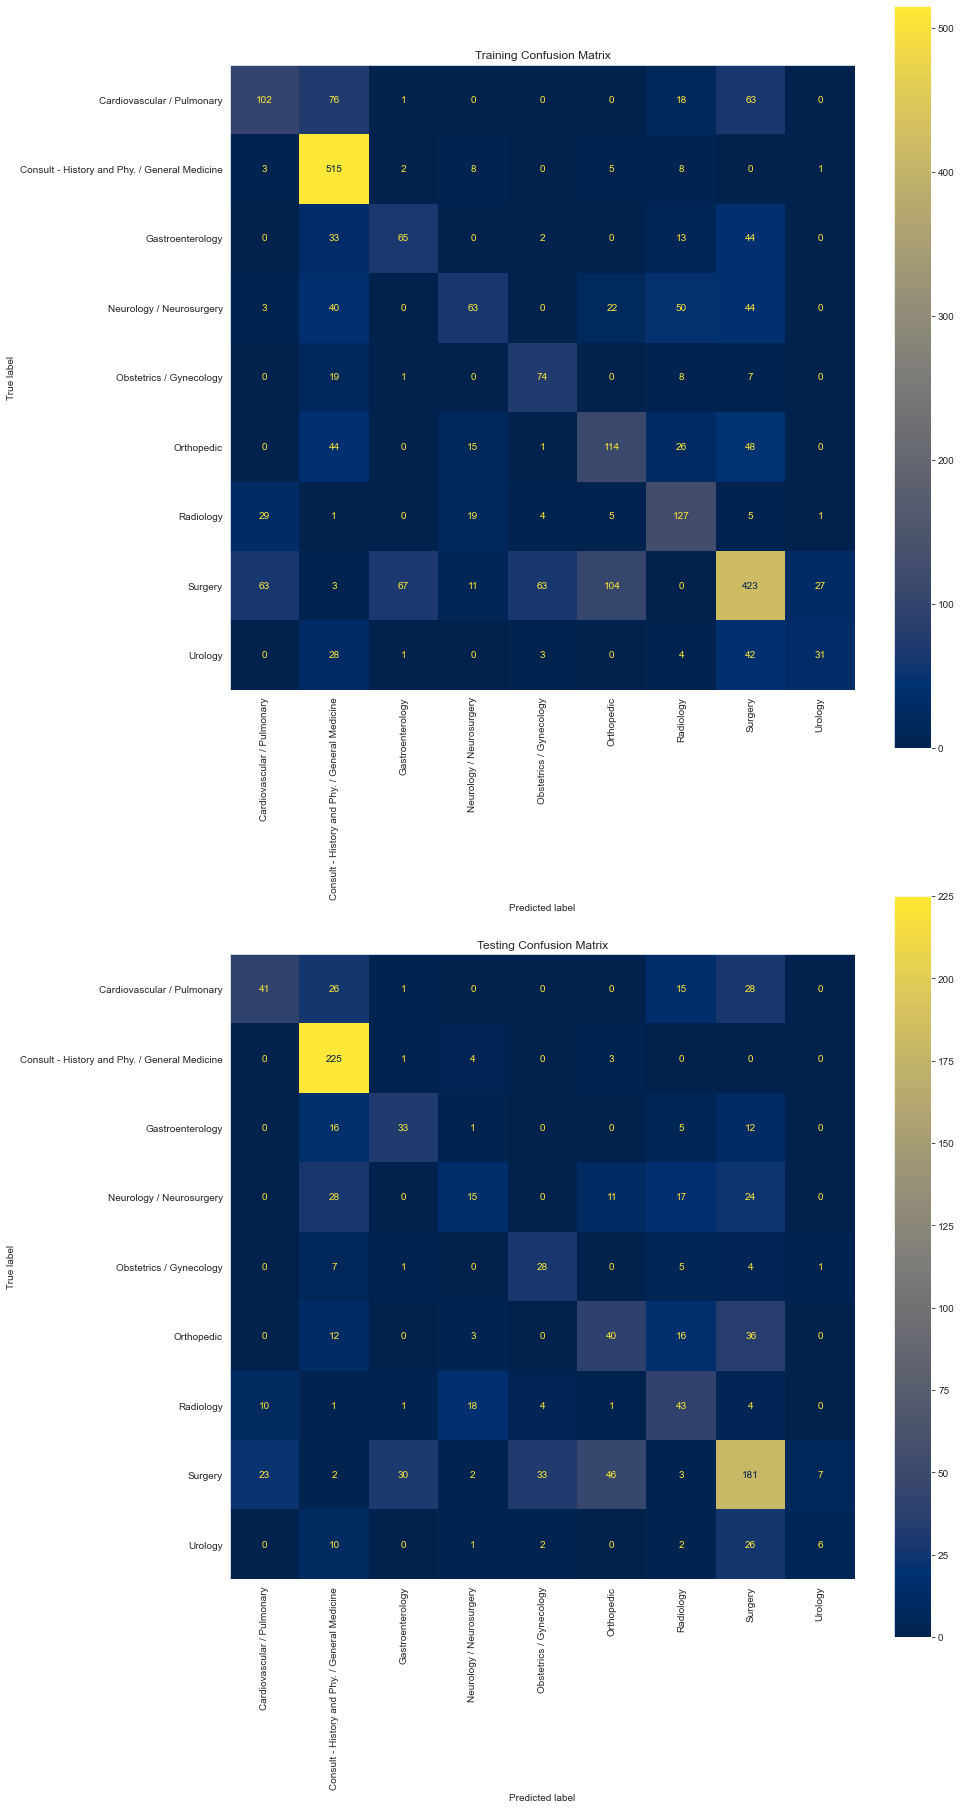

In [1504]:
best_mnb_imbal = evaluate_models(mnb_grid)

# MNB NO IMBAL

In [1481]:
pipeline = Pipeline([
    ('vec', CountVectorizer()),
    ('clf', MultinomialNB())
])


parameters = {
    # without ngram, min_df = 0.9, max_df = 0.025, alpha = 2
    # (1,3),(2,2) not helpful
    # increasing alpha increases accuracy, theoretically makes model dumber + pick majority class
    # smote did improve ever so slightly, by a couple percentage points
 
    'vec__ngram_range':((1,1),(1,2)),
    'vec__min_df': [0.025, 0.05],
    'vec__max_df': [0.7,0.8,0.9],
    'clf__alpha': [10,100]    
}

mnb_grid = GridSearchCV(pipeline, parameters, cv=5)

{'clf__alpha': 10, 'vec__max_df': 0.7, 'vec__min_df': 0.025, 'vec__ngram_range': (1, 2)}
-----------------
Training Accuracy:  0.5863793766833397
Training Precision:  0.5762489442102237
Training Recall:  0.5863793766833397
Training F1:  0.5696016873313186
-----------------
Cross-Validation Accuracy:  0.5459759893285906
-----------------
Testing Accuracy:  0.547085201793722
Testing Precision:  0.5245305703762797
Testing Recall:  0.547085201793722
Testing F1:  0.5227184571709376


Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.7, min_df=0.025, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=10))])

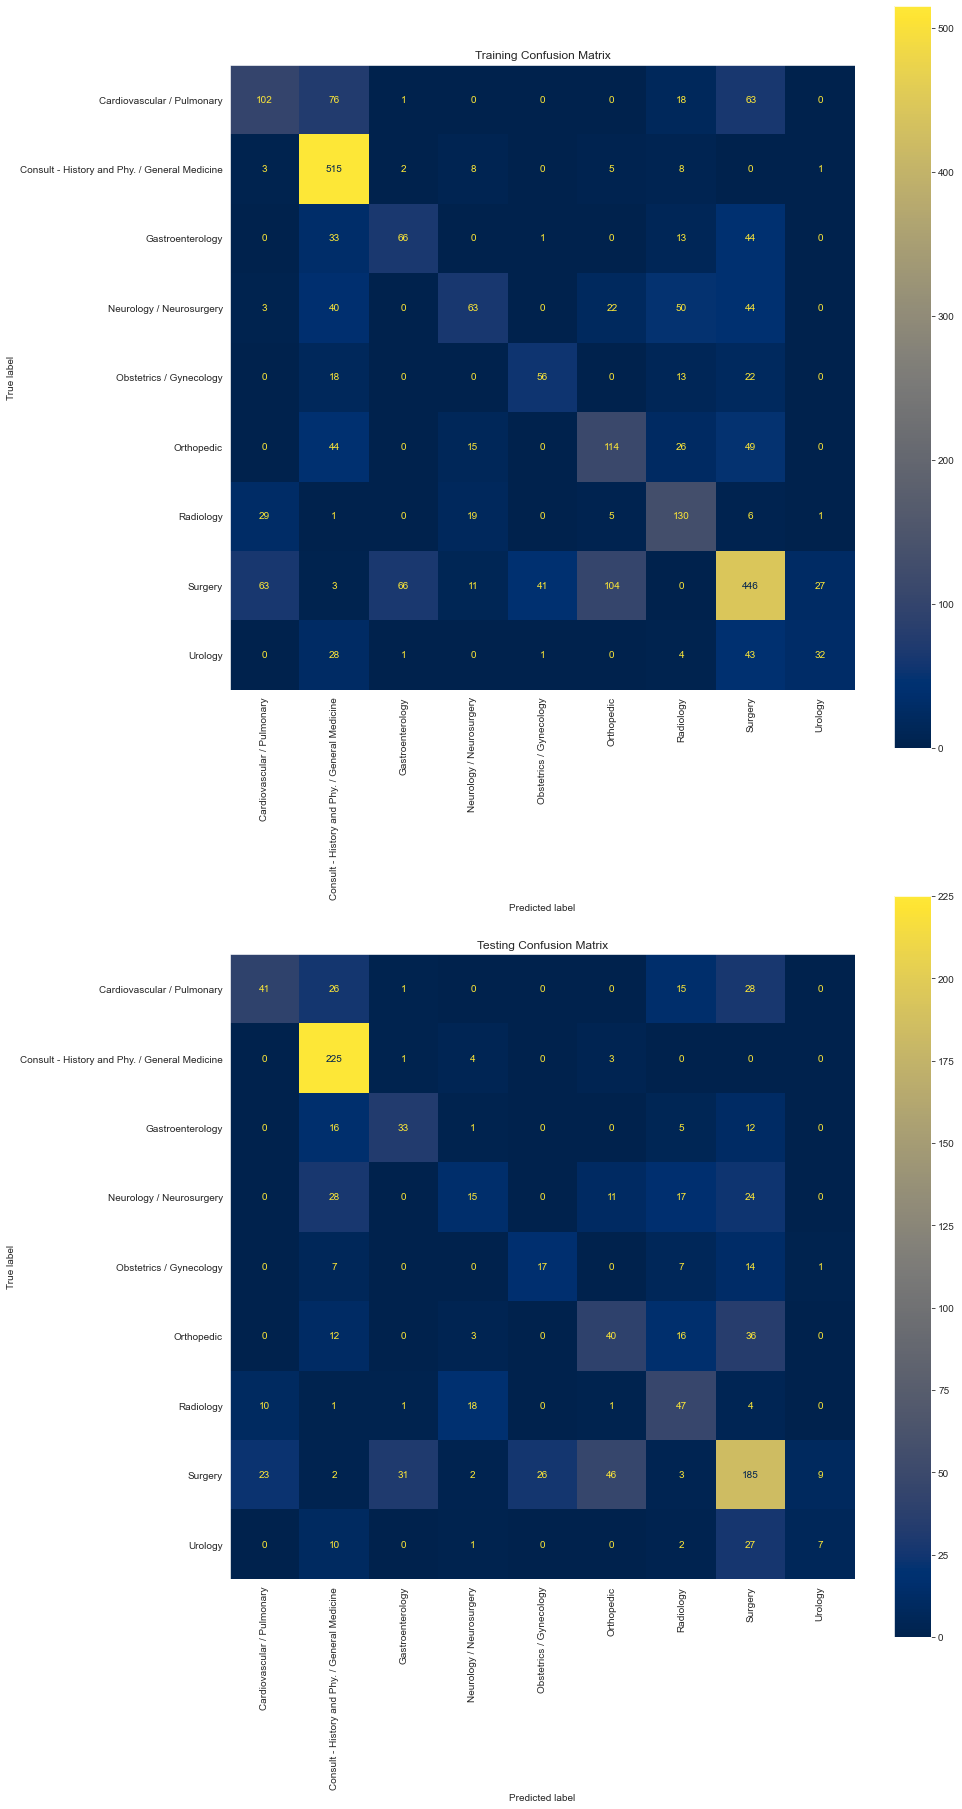

In [1482]:
evaluate_models(mnb_grid)

# MNB IMBAL TFIDF

In [1495]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('imbal', SMOTE(random_state=42)),
    ('clf', MultinomialNB())
])

# likely need to change alpha, model is 'too dumb'
# want to try without ngram_range, praveen said bad because it doesn't take into account what is important

parameters = {
    # trying without 0.7,0.8 for max_df -- worse
    'vec__ngram_range':((1,1),(1,2),(1,3)),
    'vec__min_df': [0.05],
    'vec__max_df': [0.9],
    'clf__alpha': [0.1,1,2],
    'imbal':imbalance,
    'imbal__sampling_strategy': ['minority']
}

mnb_tfidf_grid = GridSearchCV(pipeline, parameters, cv=5)

{'clf__alpha': 2, 'imbal': RandomOverSampler(random_state=42, sampling_strategy='minority'), 'imbal__sampling_strategy': 'minority', 'vec__max_df': 0.9, 'vec__min_df': 0.05, 'vec__ngram_range': (1, 3)}
-----------------
Training Accuracy:  0.5617545209696037
Training Precision:  0.5023918639150703
Training Recall:  0.5617545209696037
Training F1:  0.4879674452952128
-----------------
Cross-Validation Accuracy:  0.5413561582925746
-----------------
Testing Accuracy:  0.557847533632287
Testing Precision:  0.5513779112395618
Testing Recall:  0.557847533632287
Testing F1:  0.48200459958533654


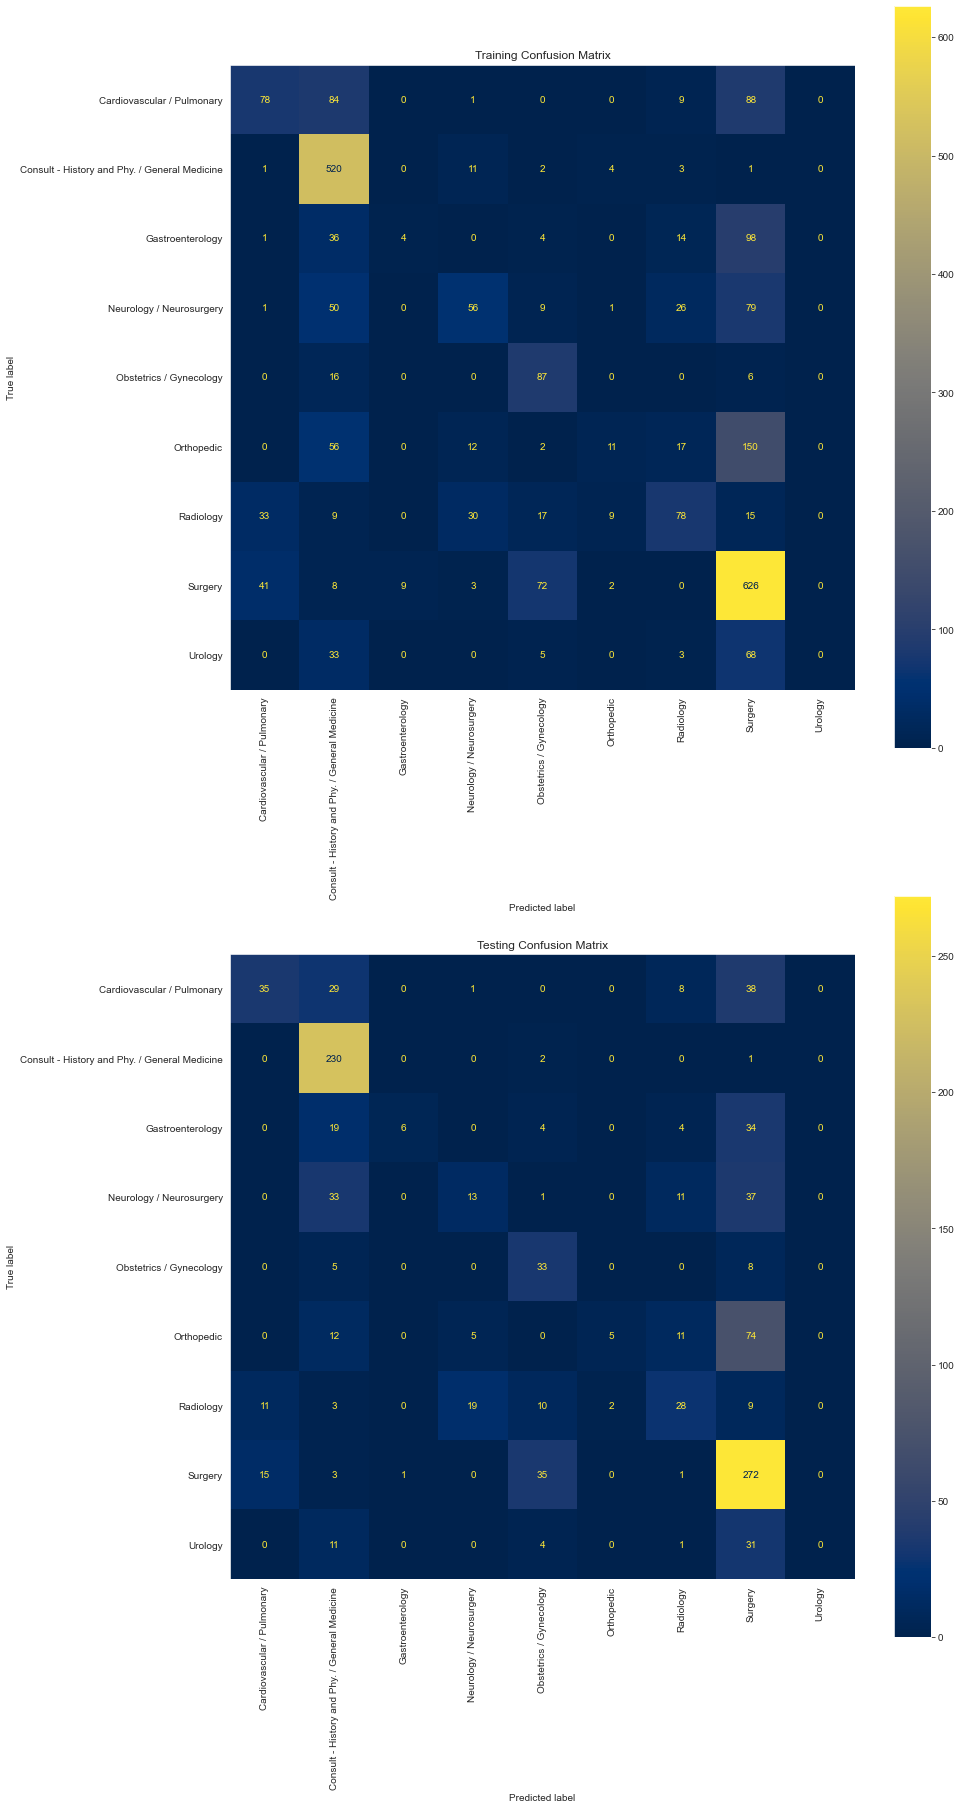

In [1496]:
best_mnb_tfidf = evaluate_models(mnb_tfidf_grid)

# CNB IMBAL COUNTVEC

In [1501]:
pipeline = Pipeline([
    ('vec', CountVectorizer()),
    ('imbal', SMOTE(random_state=42)),
    ('clf', ComplementNB())
])

parameters = {
    # without ngram_range, min_df = 0.025, max_df = 0.9
    'vec__ngram_range':((1,1),(1,2),(1,3)),
    'vec__min_df': [0.025],
    'vec__max_df': [0.9],
    'clf__alpha': [0.1,0.05],
    'imbal': imbalance,
    'imbal__sampling_strategy': ['minority','not majority']
}

cnb_grid_cvimbal = GridSearchCV(pipeline, parameters, cv=5)

{'clf__alpha': 0.1, 'imbal': SMOTE(random_state=42, sampling_strategy='not majority'), 'imbal__sampling_strategy': 'not majority', 'vec__max_df': 0.9, 'vec__min_df': 0.025, 'vec__ngram_range': (1, 3)}
-----------------
Training Accuracy:  0.5698345517506733
Training Precision:  0.5660163243793706
Training Recall:  0.5698345517506733
Training F1:  0.5525935159624106
-----------------
Cross-Validation Accuracy:  0.5340447606343559
-----------------
Testing Accuracy:  0.5461883408071749
Testing Precision:  0.5215136458110003
Testing Recall:  0.5461883408071749
Testing F1:  0.5170671594232443


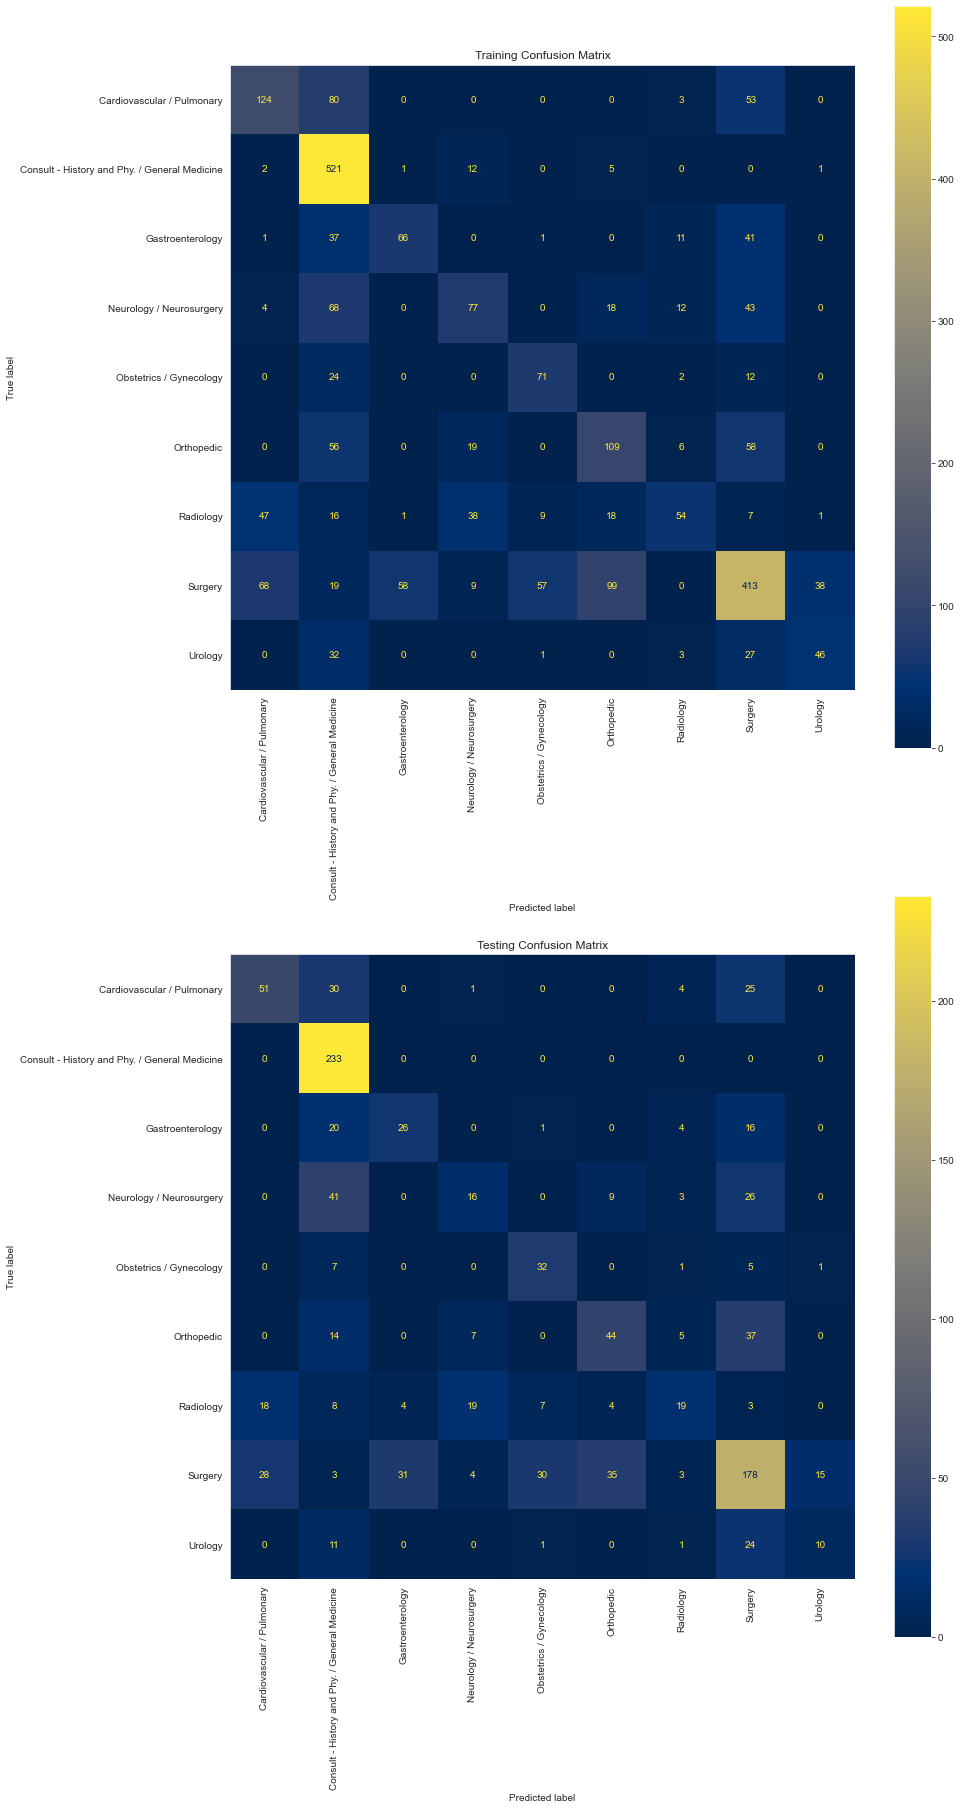

In [1502]:
best_cnb_imbal = evaluate_models(cnb_grid_cvimbal)

# CNB NO IMBAL COUNTVEC

In [1505]:
pipeline = Pipeline([
    ('vec', CountVectorizer()),
    ('clf', ComplementNB())
])

parameters = {
    # without ngram_range, min_df = 0.025, max_df = 0.9
    'vec__ngram_range':((1,1),(1,2),(1,3)),
    'vec__min_df': [0.025,0.05],
    'vec__max_df': [0.75, 0.9],
    'clf__alpha': [0.1, 1]
}

cnb_grid = GridSearchCV(pipeline, parameters, cv=5)

{'clf__alpha': 0.1, 'vec__max_df': 0.75, 'vec__min_df': 0.05, 'vec__ngram_range': (1, 1)}
-----------------
Training Accuracy:  0.532127741439015
Training Precision:  0.4844370110115383
Training Recall:  0.532127741439015
Training F1:  0.43402250596492237
-----------------
Cross-Validation Accuracy:  0.5278909144805098
-----------------
Testing Accuracy:  0.5345291479820627
Testing Precision:  0.48871028797028915
Testing Recall:  0.5345291479820627
Testing F1:  0.42914668793920824


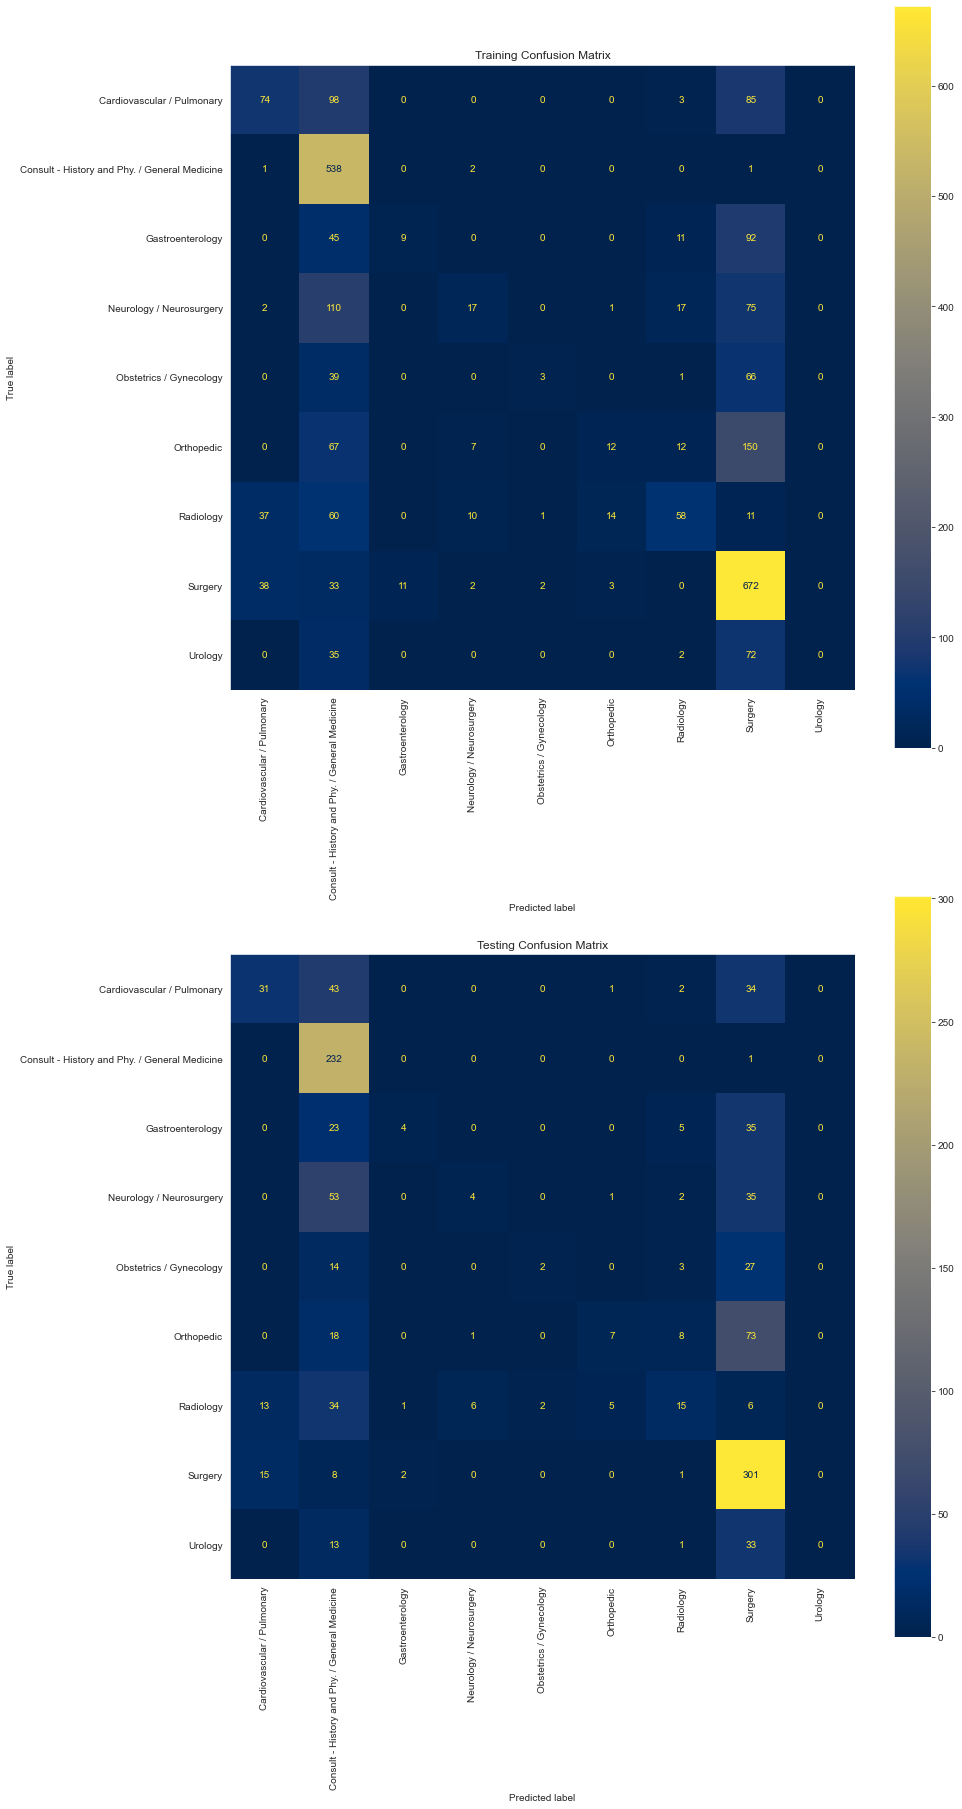

In [1506]:
best_cnb = evaluate_models(cnb_grid)

# CNB IMBAL TFIDF

In [1499]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer()),
    ('imbal', SMOTE(random_state=42)),
    ('clf', ComplementNB())
])

parameters = {
    # without ngram, min_df = 0.9, max_df = 0.05, clf = 2
    'vec__ngram_range':((1,1),(1,2),(1,3)),
    'vec__min_df': [0.025, 0.05],
    'vec__max_df': [0.7,0.9],
    'clf__alpha': [2,3,4],
    'imbal': imbalance,
    'imbal__sampling_strategy': ['minority','not majority']
}

cnb_tfidf_grid = GridSearchCV(pipeline, parameters, cv=5)

{'clf__alpha': 2, 'imbal': RandomOverSampler(random_state=42, sampling_strategy='minority'), 'imbal__sampling_strategy': 'minority', 'vec__max_df': 0.9, 'vec__min_df': 0.025, 'vec__ngram_range': (1, 2)}
-----------------
Training Accuracy:  0.5659869180454021
Training Precision:  0.5386590115480727
Training Recall:  0.5659869180454021
Training F1:  0.5065388219337261
-----------------
Cross-Validation Accuracy:  0.5340440195642507
-----------------
Testing Accuracy:  0.5641255605381166
Testing Precision:  0.5554922712113114
Testing Recall:  0.5641255605381166
Testing F1:  0.4949416930980437


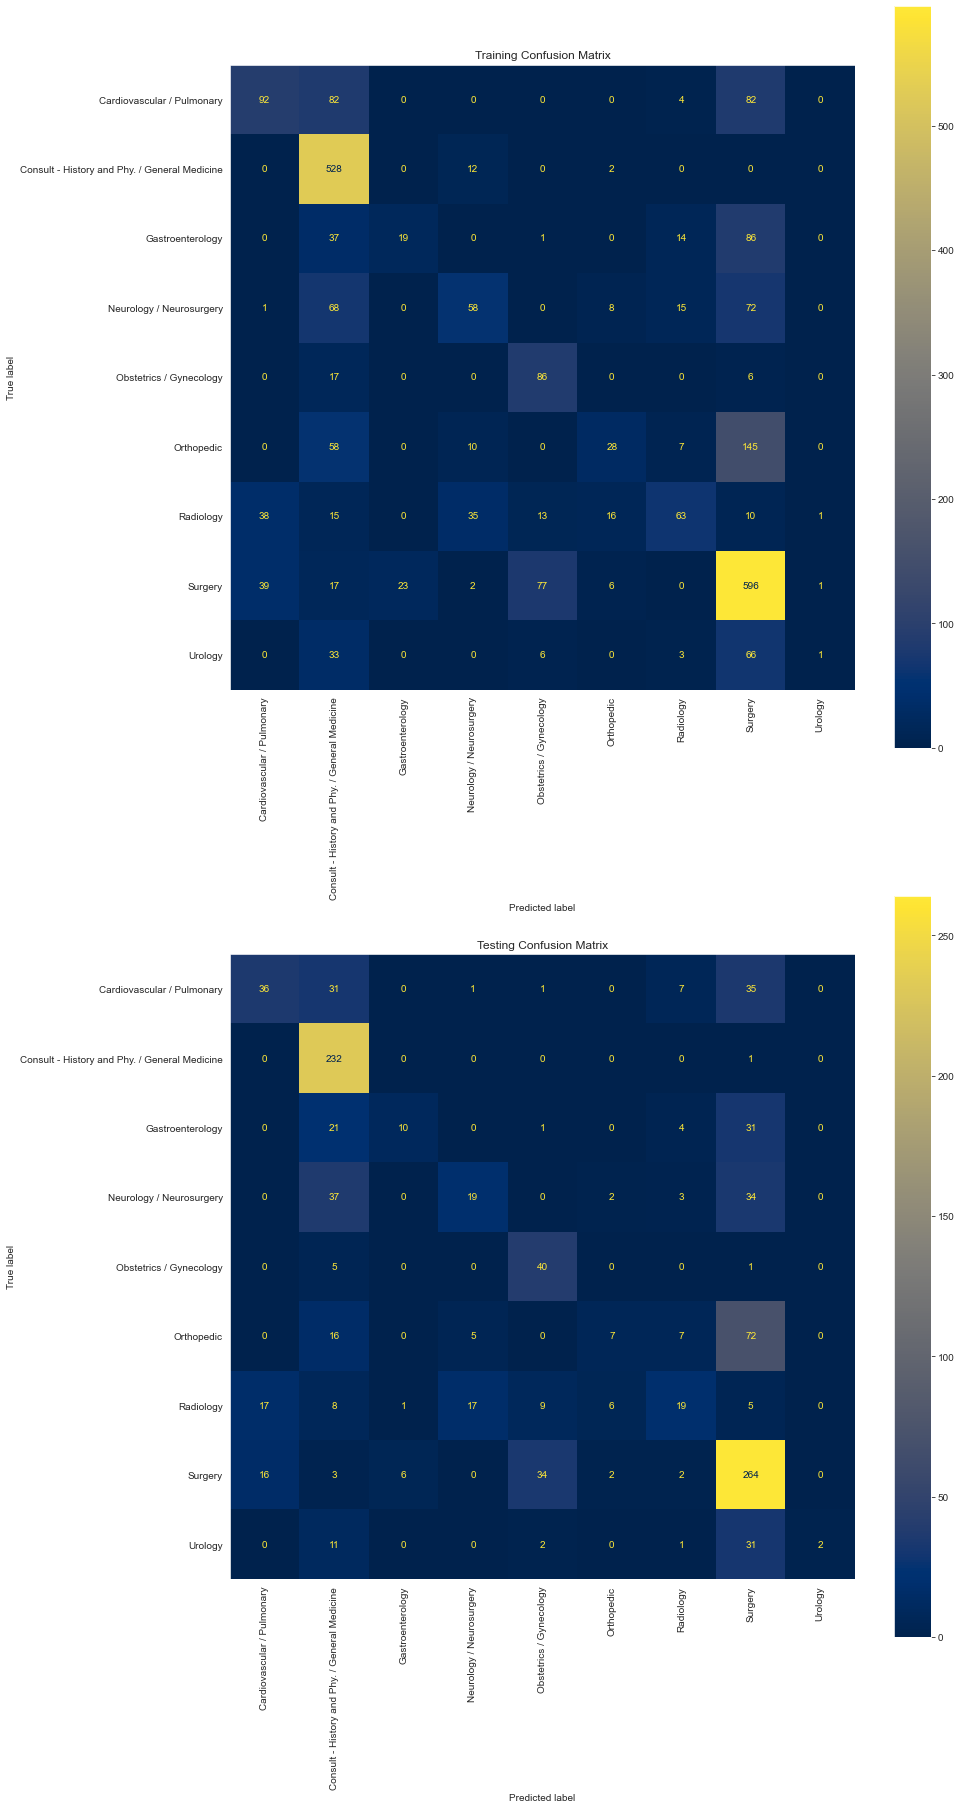

In [1500]:
best_tfidf_cnb = evaluate_models(cnb_tfidf_grid)